# Model Training-Evaluation-Selection

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.dates import date2num
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.losses import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import h5py

## Load Data

In [3]:
consumption= pd.read_pickle('../Data_Cleaned/consumption.pkl')
generation= pd.read_pickle('../Data_Cleaned/generation.pkl')
installed= pd.read_pickle('../Data_Cleaned/installed.pkl')
price= pd.read_pickle('../Data_Cleaned/price.pkl')

In [4]:
dfs=[consumption,generation,installed,price]
for df in dfs:
    df.set_index('timestamp', inplace=True)

## Resample Data

In [5]:
# resampling data by hour
consumption= consumption.resample('h').sum()
generation = generation.resample('h').sum()
# For simplicity, we only predict total electricity generation
generation= generation.sum(axis=1).to_frame(name='Electricity Generation [MWh]')

In [6]:
# save data
consumption.to_pickle('../Data_Cleaned/consumption_ready_for_forcast.pkl')
generation.to_pickle('../Data_Cleaned/generation_ready_for_forcast.pkl')

## Stateful vs. Stateless LSTM
* **Stateless**: LSTM updates parameters on batch 1 and then initiates cell states (meaning - memory, usually with zeros) for batch 2
* **Stateful**: it uses batch 1 last output cell sates as initial states for batch 2.

**When to use which?**
* When sequences in batches are related to each other (e.g. prices of one commodity), we should better use stateful mode
* Else, when one sequence represents a complete sentence, we should go with stateless mode

## Batch Size

Batch-size: which batch-size to choose?
Very important decision!

Imagine, you must learn to recognize a bird... You are presented images of different birds.

What would you prefer:

1. To see the one image at a time, make your notes about special bird quilities (set your weights) and then see another bird and so on
2. OR may be you would better learn if you see - let's say 5 - bird images at ones. May be then you can faster notice the bird's intrinsic properties?
I'd say - the second method is more efficient for humans. We need more examples of an entitiy, that we have to distinguish.

So the machines! Therefore we select a batch size of 64. Later in programming assigment we will see how the batch size impacts the prediction accuracy.

In [7]:
# defining the batch size
batch_size = 64

## Test and Training Set

With **stateful** LSTMs the trainings-set size must be divisible without remainder by the batch-size (modulo = 0).
We split our datasets with 80-20 ratio. That means we use four years recorded data (2015-2018) to train our model and then use 2019 data to evaluate our model. Once we find the best model, we use all data to create a model wich can predict values of year 2020.

In [8]:
print('\n==== Electricity Consumption Dataset ====')
# dataframe size
length = len(consumption)
print('Dataframe size: ',length)
# training set size (80%)
length *= 1 - 0.2
print('Training set size (80%)', length)

print('\n==== Electricity Generation Dataset ====')
# dataframe size
length = len(generation)
print('Dataframe size: ',length)
# training set size (80%)
length *= 1 - 0.2
print('Training set size (80%)', length,'\n')


==== Electricity Consumption Dataset ====
Dataframe size:  43824
Training set size (80%) 35059.200000000004

==== Electricity Generation Dataset ====
Dataframe size:  43824
Training set size (80%) 35059.200000000004 



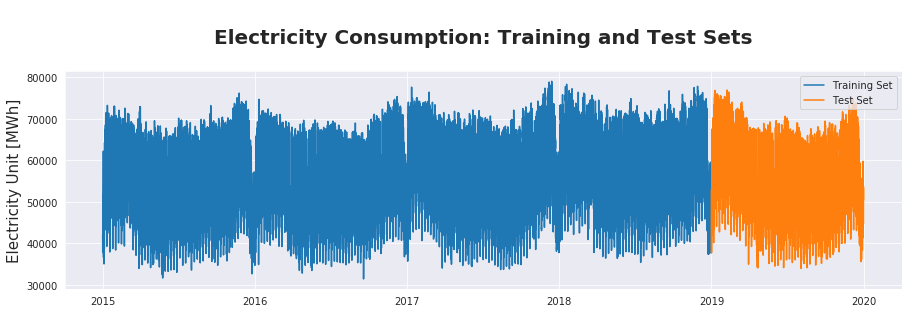

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,4))
plt.plot(consumption[:35059], label='Training Set')
plt.plot(consumption[35059:], label='Test Set')
plt.title('\nElectricity Consumption: Training and Test Sets\n', fontsize=20 ,fontweight='bold')
plt.ylabel('Electricity Unit [MWh]', fontsize=15)
plt.xlabel('')
plt.legend(loc='upper right')
plt.show()

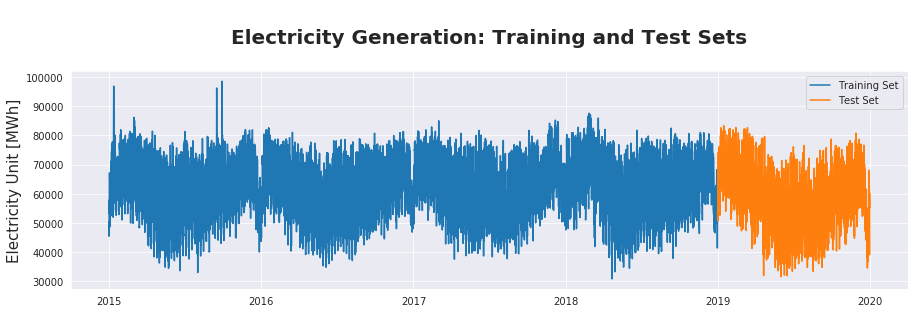

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,4))
plt.plot(generation[:35059], label='Training Set')
plt.plot(generation[35059:], label='Test Set')
plt.title('\nElectricity Generation: Training and Test Sets\n', fontsize=20 ,fontweight='bold')
plt.ylabel('Electricity Unit [MWh]', fontsize=15)
plt.xlabel('')
plt.legend(loc='upper right')
plt.show()

But as we can see, 80% of data is not divisable by our batch size. So we write a function to find the nearest divisable index.

In [11]:
# Function to calculate training size regarding batch_size
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 200,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
    return (max(train_length_values))

In [12]:
length = get_train_length(consumption, batch_size, 0.2)
print('\n==== Electricity Consumption Dataset ====')
print('Divisible training set size (almost 80%)', length)
length = get_train_length(generation, batch_size, 0.2)
print('\n==== Electricity Generation Dataset ====')
print('Divisible training set size (almost 80%)', length,'\n')


==== Electricity Consumption Dataset ====
Divisible training set size (almost 80%) 35008

==== Electricity Generation Dataset ====
Divisible training set size (almost 80%) 35008 



As the size of both dataframes are the same, I don't assign different parameters for length.

## Adding Timesteps

In [13]:
# Set time steps to 7 days
timesteps=24*7
# Adding timesteps * 2
upper_train = length + timesteps*2

# Set y_train variable for consumption df
consumption_train_df = consumption[0:upper_train]
consumption_y_train = consumption_train_df.iloc[:,].values
print('\nTraining Sets Shapes after Adding Timesteps:\n')
print('==== Electricity Consumption Dataset ====')
print('Training Set Shape:',consumption_y_train.shape)

# Set y_train variable for generation df
generation_train_df = generation[0:upper_train]
generation_y_train = generation_train_df.iloc[:,].values
print('\n==== Electricity Generation Dataset ====')
print('Training Set Shape:',generation_y_train.shape,'\n')


Training Sets Shapes after Adding Timesteps:

==== Electricity Consumption Dataset ====
Training Set Shape: (35344, 1)

==== Electricity Generation Dataset ====
Training Set Shape: (35344, 1) 



## Feature Scaling

In [14]:
#scale between 0 and 1. the weights are esier to find.
sc = MinMaxScaler(feature_range = (0, 1))
consumption_y_train_scaled = sc.fit_transform(np.float64(consumption_y_train))
generation_y_train_scaled = sc.fit_transform(np.float64(generation_y_train))

In [15]:
print('\nElectricity Generation Dataframe:\n')
print('Before Scaling:\n\n', generation_y_train[:3],'\n')
print('After Scaling:\n\n', generation_y_train_scaled[:3],'\n')


Electricity Generation Dataframe:

Before Scaling:

 [[50432.]
 [48756.]
 [48040.]] 

After Scaling:

 [[0.28926323]
 [0.2644761 ]
 [0.25388685]] 



## Creating a data structure with n timesteps

In [16]:
# Empty Lists to store X_train and y_train
consumption_X_train_matrix = []
consumption_y_train_matrix = []
# Creating a data structure with n timesteps
for i in range(timesteps, length + timesteps):
    #create X_train matrix
    #24*7 items per array (timestep) 
    consumption_X_train_matrix.append(consumption_y_train_scaled[i-timesteps:i,0])
    #create Y_train matrix
    #24*7 items per array (timestep)
    consumption_y_train_matrix.append(consumption_y_train_scaled[i:i+timesteps,0])
    
# reapeat all of these steps fot generation dataframe
generation_X_train_matrix = []
generation_y_train_matrix = []
for i in range(timesteps, length + timesteps):
    generation_X_train_matrix.append(generation_y_train_scaled[i-timesteps:i,0])
    generation_y_train_matrix.append(generation_y_train_scaled[i:i+timesteps,0])

In [17]:
# Check shape
print('X_train sets shape:', np.array(consumption_X_train_matrix).shape)
print('y_train sets shape:', np.array(consumption_y_train_matrix).shape)

X_train sets shape: (35008, 168)
y_train sets shape: (35008, 168)


## Reshape

In [18]:
# Turn list into numpy array
consumption_X_train_matrix = np.array(consumption_X_train_matrix)
consumption_y_train_matrix = np.array(consumption_y_train_matrix)
# reshape arrays
consumption_X_train_reshaped = np.reshape(consumption_X_train_matrix, 
                                         (consumption_X_train_matrix.shape[0], 
                                          consumption_X_train_matrix.shape[1], 1))
consumption_y_train_reshaped = np.reshape(consumption_y_train_matrix, 
                                         (consumption_y_train_matrix.shape[0], 
                                          consumption_y_train_matrix.shape[1], 1))

# Repeat the same stes for generatin dataframe
generation_X_train_matrix = np.array(generation_X_train_matrix)
generation_y_train_matrix = np.array(generation_y_train_matrix)
generation_X_train_reshaped = np.reshape(generation_X_train_matrix, 
                                         (generation_X_train_matrix.shape[0], 
                                          generation_X_train_matrix.shape[1], 1))
generation_y_train_reshaped = np.reshape(generation_y_train_matrix, 
                                         (generation_y_train_matrix.shape[0], 
                                          generation_y_train_matrix.shape[1], 1))

In [19]:
# Check shapes
print('X_train sets shape:', generation_X_train_reshaped.shape)
print('y_train sets shape:', generation_y_train_reshaped.shape)

X_train sets shape: (35008, 168, 1)
y_train sets shape: (35008, 168, 1)


## Building the LSTM

In [20]:
# Initialising the LSTM Model with MSE Loss-Function
# Using Functional API, each layer output is the input of next layer

# Input
inputs = Input(batch_shape=(batch_size,timesteps,1))

# Layer 1: LSTM 
lstm_1 = LSTM(12, 
                activation='tanh', 
                recurrent_activation='sigmoid', 
                stateful=True, 
                return_sequences=True)(inputs)
# Layer 2: LSTM 
lstm_2 = LSTM(12, 
                activation='tanh', 
                recurrent_activation='sigmoid', 
                stateful=True, 
                return_sequences=True)(lstm_1)
# Output
output = Dense(units = 1)(lstm_2)

# Sticking all layers into a Model
regressor = Model(inputs=inputs, outputs = output)

#adam is fast starting off and then gets slower and more precise
regressor.compile(optimizer='adam', loss = mean_squared_error)

In [21]:
# Check the model summary
regressor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 168, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (64, 168, 12)             672       
_________________________________________________________________
lstm_1 (LSTM)                (64, 168, 12)             1200      
_________________________________________________________________
dense (Dense)                (64, 168, 1)              13        
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


This is how the param numbers are calculated:

\begin{equation}
          \textbf{PARAMETERS} = \textbf4 \times \textbf{ LSTM outputs size} \times (\textbf{weights LSTM inputs size} + \textbf{weights LSTM outputs size} + 1 \textbf{ bias variable})
    \end{equation}

In [22]:
# For example for lstm layers
print('1st LSTM layer Params: ',4*12*(1+12+1))
print('2st LSTM layer Params: ',4*12*(12+12+1))

1st LSTM layer Params:  672
2st LSTM layer Params:  1200


## Run LSTM Model for Electricity Consumption

This model is so heavy that I cannot run it on my local computer. Therefore I ran it on IBM Watson Studio, then saved it to IBM Cloud Open Storage and then downloaded it. Now, we can import the model and evaluate it.

```python
epochs = 5

# start time
start=time.time()

#Statefull
for i in range(epochs):
    print("\nEpoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor.fit(consumption_X_train_reshaped, consumption_y_train_reshaped, 
                  shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor.reset_states()

# duration of training the model
duration=time.time()-start
```

In [23]:
regressor_loaded = load_model(filepath="../Models/LSTM_initial_Model_Consumption.h5")

## Test Set

In [24]:
# Function that extarct a divisable index regarding batch
def get_test_length(dataset, batch_size):
    test_length_values = []
    for x in range(len(dataset) - 500, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            #print(x)
    return (max(test_length_values))

In [25]:
test_length = get_test_length(consumption, batch_size)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print('Test Set Size:' ,testset_length)

Test Set Size: 8128


In [26]:
print('Train Set Endpoint: ', upper_train)
print('Test Set Endpoint: ', upper_test)
print('Size of Dataframe: ',len(consumption))

Train Set Endpoint:  35344
Test Set Endpoint:  43808
Size of Dataframe:  43824


In [27]:
# construct test set

#subsetting
con_test = consumption[upper_train:upper_test] 
con_test_set = con_test.iloc[:,].values

#scaling
consumption_X_test_scaled = sc.fit_transform(np.float64(con_test_set))

#creating input data
consumption_X_test_matrix = []
for i in range(timesteps, testset_length + timesteps):
    consumption_X_test_matrix.append(consumption_X_test_scaled[i-timesteps:i, 0])
consumption_X_test_matrix = np.array(consumption_X_test_matrix)


#reshaping
consumption_X_test_reshaped = np.reshape(consumption_X_test_matrix, 
                                         (consumption_X_test_matrix.shape[0], 
                                          consumption_X_test_matrix.shape[1], 1))


In [28]:
print('Test Set Shape:', consumption_X_test_reshaped.shape)

Test Set Shape: (8128, 168, 1)


## Prediction

In [29]:
consumption_y_hat = regressor_loaded.predict(consumption_X_test_reshaped, batch_size=batch_size)
regressor_loaded.reset_states()

print('Predicted Set Shape:', consumption_y_hat.shape)

Predicted Set Shape: (8128, 168, 1)


In [30]:
#reshaping
consumption_y_hat = np.reshape(consumption_y_hat, 
                                (consumption_y_hat.shape[0], 
                                consumption_y_hat.shape[1]))

print('Predicted Set Shape After reshaping:', consumption_y_hat.shape)

Predicted Set Shape After reshaping: (8128, 168)


In [31]:
#inverse transform
consumption_y_hat = sc.inverse_transform(consumption_y_hat)

In [32]:
#creating y_pred data
consumption_y_pred = []

for j in range(0, testset_length - timesteps):
    consumption_y_pred = np.append(consumption_y_pred, consumption_y_hat[j, timesteps-1])

# reshaping
consumption_y_pred = np.reshape(consumption_y_pred, (consumption_y_pred.shape[0], 1))

print('Predicted Values: ', consumption_y_pred.shape)

Predicted Values:  (7960, 1)


## Evaluating

In [33]:
from sklearn.metrics import mean_squared_error

In [56]:
RMSE= np.sqrt(mean_squared_error(consumption_y_pred[0:len(consumption_y_pred) - timesteps].flatten(),
                  con_test_set[timesteps:len(consumption_y_pred)].flatten()))
print('RMSE: ',round(RMSE,1))

RMSE:  3651.1


In [55]:
mean= np.mean(con_test_set[timesteps:len(consumption_y_pred)].flatten())
print('Loss: ' ,round((RMSE/mean)*100,2),'%')

Loss:  6.62 %


In [49]:
x_index = consumption[upper_train+timesteps:upper_train+len(consumption_y_pred)].index

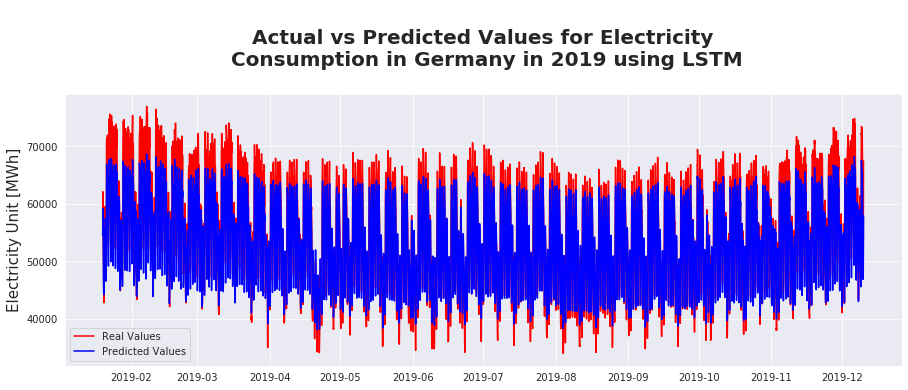

In [57]:
# Visualising the results
fig= plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(x_index,con_test_set[timesteps:len(consumption_y_pred)].astype(float), 
         color = 'red', label = 'Real Values')
plt.plot(x_index,consumption_y_pred[0:len(consumption_y_pred) - timesteps].astype(float), 
         color = 'blue', label = 'Predicted Values')

plt.title('\nActual vs Predicted Values for Electricity\n Consumption in Germany in 2019 using LSTM\n', 
          fontsize=20 ,fontweight='bold')
plt.xlabel('')
plt.ylabel('Electricity Unit [MWh]', fontsize=15)
plt.legend()
plt.show()

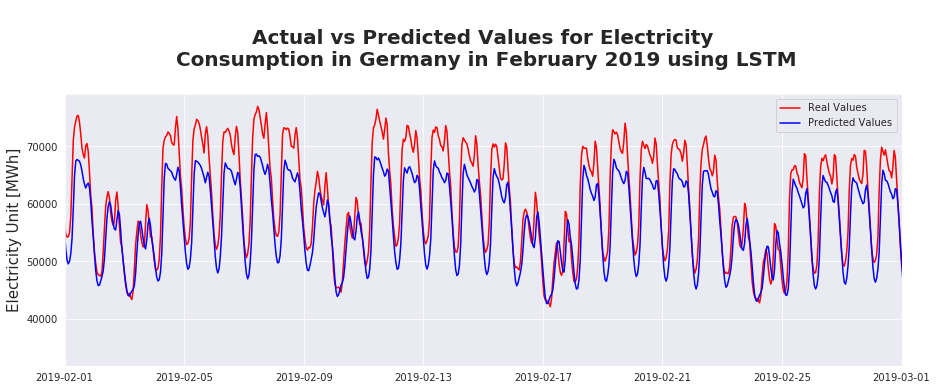

In [51]:
# Visualising the results
fig= plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(x_index,con_test_set[timesteps:len(consumption_y_pred)].astype(float), 
         color = 'red', label = 'Real Values')
plt.plot(x_index,consumption_y_pred[0:len(consumption_y_pred) - timesteps].astype(float), 
         color = 'blue', label = 'Predicted Values')

plt.title('\nActual vs Predicted Values for Electricity\n Consumption in Germany in February 2019 using LSTM\n', 
          fontsize=20 ,fontweight='bold')
plt.xlabel('')
plt.xlim(date2num(pd.to_datetime(['2019-02-01','2019-03-01'])))
plt.ylabel('Electricity Unit [MWh]', fontsize=15)
plt.legend()
plt.show()

## Run LSTM Model for Electricity Generation

The model is ran on IBM Watson Studio. It is then stored to IBM Object Storage and now we can download it and load it.

In [194]:
regressor_loaded = load_model(filepath="../Models/LSTM_initial_Model_Generation.h5")

## Test Set

In [195]:
test_length = get_test_length(generation, batch_size)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print('Test Set Size:' ,testset_length)

Test Set Size: 8128


In [196]:
print('Train Set Endpoint: ', upper_train)
print('Test Set Endpoint: ', upper_test)
print('Size of Dataframe: ',len(generation))

Train Set Endpoint:  35344
Test Set Endpoint:  43808
Size of Dataframe:  43824


In [197]:
# construct test set

#subsetting
gen_test = generation[upper_train:upper_test] 
gen_test_set = gen_test.iloc[:,].values

#scaling
generation_X_test_scaled = sc.fit_transform(np.float64(gen_test_set))

#creating input data
generation_X_test_matrix = []
for i in range(timesteps, testset_length + timesteps):
    generation_X_test_matrix.append(generation_X_test_scaled[i-timesteps:i, 0])
generation_X_test_matrix = np.array(generation_X_test_matrix)


#reshaping
generation_X_test_reshaped = np.reshape(generation_X_test_matrix, 
                                         (generation_X_test_matrix.shape[0], 
                                          generation_X_test_matrix.shape[1], 1))


In [198]:
print('Test Set Shape:', generation_X_test_reshaped.shape)

Test Set Shape: (8128, 168, 1)


## Prediction

In [199]:
generation_y_hat = regressor_loaded.predict(generation_X_test_reshaped, batch_size=batch_size)
regressor_loaded.reset_states()

print('Predicted Set Shape:', generation_y_hat.shape)

Predicted Set Shape: (8128, 168, 1)


In [200]:
#reshaping
generation_y_hat = np.reshape(generation_y_hat, 
                                (generation_y_hat.shape[0], 
                                generation_y_hat.shape[1]))

print('Predicted Set Shape After reshaping:', generation_y_hat.shape)

Predicted Set Shape After reshaping: (8128, 168)


In [201]:
#inverse transform
generation_y_hat = sc.inverse_transform(generation_y_hat)

In [202]:
#creating y_pred data
generation_y_pred = []

for j in range(0, testset_length - timesteps):
    generation_y_pred = np.append(generation_y_pred, generation_y_hat[j, timesteps-1])

# reshaping
generation_y_pred = np.reshape(generation_y_pred, (generation_y_pred.shape[0], 1))

print('Predicted Values: ', generation_y_pred.shape)

Predicted Values:  (7960, 1)


## Evaluating

In [203]:
from sklearn.metrics import mean_squared_error

In [222]:
y_true= gen_test_set[timesteps:len(generation_y_pred)].flatten()
y_pred= generation_y_pred[0:len(generation_y_pred) - timesteps].flatten()

In [228]:
RMSE= np.sqrt(mean_squared_error(y_true,y_pred))
print('RMSE:',RMSE)

RMSE: 5803.153205714402


In [239]:
mean= np.mean(y_true)
print('Loss: ' ,round((RMSE/mean)*100,2),'%')

Loss:  10.05 %


In [ ]:
x_index = generation[upper_train+timesteps:upper_train+len(generation_y_pred)].index

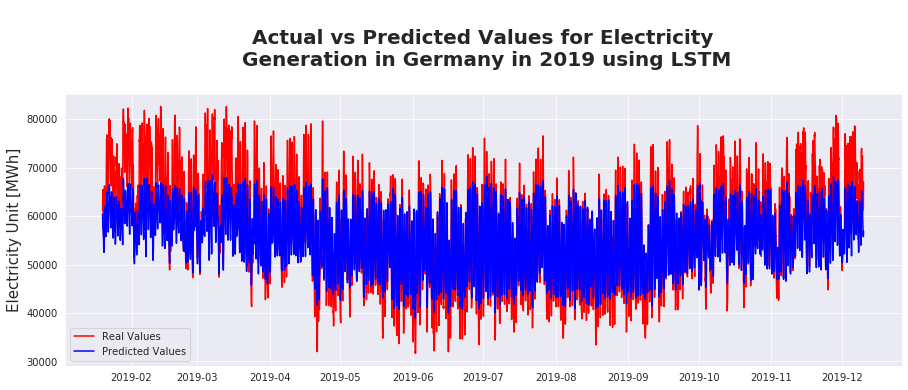

In [205]:
# Visualising the results
fig= plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(x_index,gen_test_set[timesteps:len(generation_y_pred)].astype(float), 
         color = 'red', label = 'Real Values')
plt.plot(x_index,generation_y_pred[0:len(generation_y_pred) - timesteps].astype(float), 
         color = 'blue', label = 'Predicted Values')

plt.title('\nActual vs Predicted Values for Electricity\n Generation in Germany in 2019 using LSTM\n', 
          fontsize=20 ,fontweight='bold')
plt.xlabel('')
plt.ylabel('Electricity Unit [MWh]', fontsize=15)
plt.legend()
plt.show()

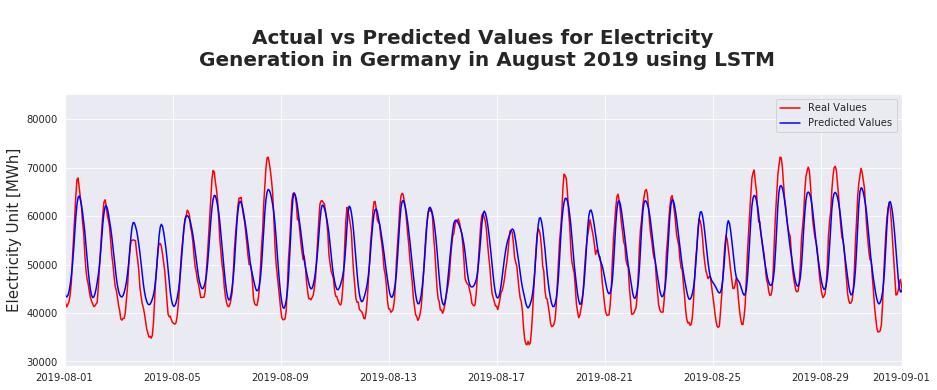

In [208]:
# Visualising the results
fig= plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(x_index,gen_test_set[timesteps:len(generation_y_pred)].astype(float), 
         color = 'red', label = 'Real Values')
plt.plot(x_index,generation_y_pred[0:len(generation_y_pred) - timesteps].astype(float), 
         color = 'blue', label = 'Predicted Values')

plt.title('\nActual vs Predicted Values for Electricity\n Generation in Germany in August 2019 using LSTM\n', 
          fontsize=20 ,fontweight='bold')
plt.xlabel('')
plt.xlim(date2num(pd.to_datetime(['2019-08-01','2019-09-01'])))
plt.ylabel('Electricity Unit [MWh]', fontsize=15)
plt.legend()
plt.show()